# Visualize and Analyze

This notebook will explore the data we downloaded in the Customize and Access notebook by performing the following steps:

* Load data from our Amazon S3 bucket
* Read in ATL03 and ATL07 data and plot against MODIS Corrected Reflectance (true color) imagery
* Overlay ATL07 data over MODIS IST
* Extract MODIS IST values along ICESat-2 heights
* Plot MODIS IST and ICESat-2 height

4. Demonstrate how to extract ICESat-2 elevation data using MODIS IST data

### Import packages

Need to install `plotly` on top of Pangeo

In [ ]:
!conda install -c plotly plotly=4.3.0 -y

Installing `awscli` on top of Pangeo 

In [ ]:
!conda install awscli -y

In [1]:
from collections import defaultdict

from osgeo import gdal, osr
import math
import h5py
import xarray as xr
import pyproj
import pandas as pd
from shapely.geometry import Point,Polygon

import pyresample as prs
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import hvplot.pandas  # Adds the 'hvplot' method to pandas objects
import hvplot.xarray  # Adds the 'hvplot' method to xarray objects
#import plotly.graph_objects as go
#from plotly.offline import iplot
import rasterio
import functions

# from pathlib import Path
# import numpy as np
#import geopandas as gpd
from datetime import datetime, timedelta

%matplotlib inline

Need to upgrade `pyproj` on this Pangeo environment. Had some issues getting this to install in our environment but this worked:

In [ ]:
import sys
!{sys.executable} -m pip install pyproj==2.4.1

In [ ]:
%run functions.py

In [ ]:
!conda list | grep pyproj

## Load data from Amazon s3 bucket

In [ ]:
!aws --no-sign-request --region=us-west-2 s3 sync s3://nsidc-agu-tutorial-data/ Outputs

### Load ATL03 and ATL07 granules into dataframes

We will start by defining variables to extract and combine as a single dataframe:

In [2]:
VARIABLES = {
    'ATL03': [
        '/gt1l/heights/delta_time',
        '/gt1l/heights/h_ph',
        '/gt1l/heights/lat_ph',
        '/gt1l/heights/lon_ph',
        '/gt1l/heights/signal_conf_ph',
        '/gt2l/heights/delta_time',
        '/gt2l/heights/h_ph',
        '/gt2l/heights/lat_ph',
        '/gt2l/heights/lon_ph',
        '/gt2l/heights/signal_conf_ph',
        '/gt3l/heights/delta_time',
        '/gt3l/heights/h_ph',
        '/gt3l/heights/lat_ph',
        '/gt3l/heights/lon_ph',
        '/gt3l/heights/signal_conf_ph'
    ],
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_confidence',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt1l/sea_ice_segments/heights/height_segment_quality',
        '/gt1l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_confidence',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/heights/height_segment_quality',
        '/gt2l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_confidence',
        '/gt3l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/heights/height_segment_quality',
        '/gt3l/sea_ice_segments/heights/height_segment_surface_error_est'
    ]
}

#### We will use the load_icesat2_as_dataframe function from our functions module to load points from our ATL03 and ATL07 files:

In [3]:
# Load ATL03 and ATL07 granules and combine into single ATL03 and ATL07 dataframes

df_07_101341 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323101341_12980201_002_01.h5', VARIABLES)
df_07_211343 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323211343_13050201_002_01.h5', VARIABLES)


# Running out of memory on these:
# #df_03_103438 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323103438_12980204_002_01.h5', VARIABLES)
# df_03_103947 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323103947_12980205_002_01.h5', VARIABLES)
# df_03_212915 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323212915_13050203_002_01.h5', VARIABLES)
# #df_03_213440 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323213440_13050204_002_01.h5', VARIABLES)

atl07_frames = [df_07_101341, df_07_211343]
atl07_df = pd.concat(atl07_frames,ignore_index=True)

#atl03_frames = [df_03_103438, df_03_103947, df_03_212915, df_03_213440]
#atl03_df = pd.concat(atl03_frames,ignore_index=True)

atl07_df

beam    delta_time  height_segment_confidence  height_segment_height  \
0       gt2l  3.857279e+07                   0.008960               0.124621   
1       gt2l  3.857279e+07                   0.007993               0.124729   
2       gt2l  3.857279e+07                   0.010767               0.076839   
3       gt2l  3.857279e+07                   0.012878               0.129150   
4       gt2l  3.857279e+07                   0.011868               0.178669   
...      ...           ...                        ...                    ...   
588501  gt3l  3.861208e+07                   0.016489               0.201232   
588502  gt3l  3.861208e+07                   0.012298               0.194118   
588503  gt3l  3.861208e+07                   0.016944               0.068114   
588504  gt3l  3.861208e+07                   0.016304               0.127031   
588505  gt3l  3.861208e+07                   0.018551               0.172868   

        height_segment_quality  height_segment_surface_error_est   latitude  \
0                            1                          0.019217  80.063590   
1                            1                          0.019816  80.063539   
2                            1                          0.020061  80.063475   
3                            1                          0.017499  80.063420   
4                            1                          0.019174  80.063362   
...                        ...                               ...        ...   
588501                       0                          0.021107  80.062202   
588502                       0                          0.022899  80.062584   
588503                       0                          0.015224  80.062914   
588504                       0                          0.016116  80.063195   
588505                       0                          0.016456  80.063504   

         longitude                                           filename  
0       152.165305  processed_ATL07-01_20190323101341_12980201_002...  
1       152.165218  processed_ATL07-01_20190323101341_12980201_002...  
2       152.165108  processed_ATL07-01_20190323101341_12980201_002...  
3       152.165014  processed_ATL07-01_20190323101341_12980201_002...  
4       152.164913  processed_ATL07-01_20190323101341_12980201_002...  
...            ...                                                ...  
588501  143.721685  processed_ATL07-01_20190323211343_13050201_002...  
588502  143.721207  processed_ATL07-01_20190323211343_13050201_002...  
588503  143.720796  processed_ATL07-01_20190323211343_13050201_002...  
588504  143.720447  processed_ATL07-01_20190323211343_13050201_002...  
588505  143.720068  processed_ATL07-01_20190323211343_13050201_002...  

[588506 rows x 9 columns]

#### We will use the convert_to_gdf function from our functions module to convert our DataFrame with 'longitude' and 'latitude' columns to a GeoDataFrame:

In [4]:
gdf_all = functions.convert_to_gdf(atl07_df)
gdf_single = functions.convert_to_gdf(df_07_101341)

### Load MODIS Corrected Reflectance (true color) image

Created GeoTIFF from Worldview: https://go.nasa.gov/2OjfDSa

In [5]:
# read geotiff image from gdal 

gdal.UseExceptions()

fname = './Outputs/snapshot-2019-03-23T00_00_00Z_polar.tiff'

ds = gdal.Open(fname)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print(inproj)

PROJCS["unnamed",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",70],
    PARAMETER["central_meridian",-45],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]


In [6]:
inproj.ExportToProj4()

'+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs '

### Load MODIS Ice Surface Temperature file

We'll start by choosing a single MODIS granule to be used in our analysis below. What is the best MODIS granules to use out of the 13 returned?

I can use Earthdata Search to easily visualize the coverage of each granule:
https://search.earthdata.nasa.gov/search/granules?p=C1000001160-NSIDC_ECS&q=mod29&sb=140%2C72%2C153%2C80&m=80.14349326047419!-42.27686414753069!0!0!0!0%2C2&qt=2019-03-23T00%3A00%3A00.000Z%2C2019-03-23T23%3A59%3A59.999Z&tl=1557787959!4!!

These have full coverage over our study area:

* MOD29.A2019082.0810.006.2019082191746.hdf
* MOD29.A2019082.0630.006.2019082191633.hdf
* MOD29.A2019082.0455.006.2019082132032.hdf
* MOD29.A2019082.0945.006.2019082191513.hdf

And this looks like the best data according to the browse images:

* MOD29.A2019082.0140.006.2019082132036.hdf



#### Now let's load our MOD29 file into xarray:

In [7]:
# Define local filepath and open as xarray

filepath = './Outputs/MOD29_A2019082_0140_006_2019082132036_HEGOUT.hdf'

mod29 = xr.open_dataset(filepath)
mod29

<xarray.Dataset>
Dimensions:                           (Along_swath_lines_1km:MOD_Swath_Sea_Ice: 932, Coarse_swath_lines_5km:MOD_Swath_Sea_Ice: 932, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice: 389, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice: 389)
Dimensions without coordinates: Along_swath_lines_1km:MOD_Swath_Sea_Ice, Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice
Data variables:
    Latitude                          (Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice) float32 ...
    Longitude                         (Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice) float32 ...
    Sea_Ice_by_Reflectance            (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
    Sea_Ice_by_Reflectance_Pixel_QA   (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
 

## Visualize data with MODIS Corrected Reflectance (true color) imagery 

Walt's notes: 
* Overlay ICESat-2 tracks on MODIS Corrected Reflectance as a 3-D plot or using cartopy
    * Overlay photon/height/freeboard on WorldView imagery
    * Example of visualization of data – not really useful for analysis but “pretty” image with qualitative information
    * Higher ATL07 heights along fast ice, lower heights over thin ice and then increasing height.
    * ATL03 should show fewer photon returns over open water and thin ice

In [8]:
# Read in data using rasterio

fname = './Outputs/snapshot-2019-03-23T00_00_00Z_polar.tiff'
source = rasterio.open(fname, 'r')
bounds = (source.bounds.left, source.bounds.right, \
          source.bounds.bottom, source.bounds.top)

In [9]:
bounds

(-725504.0, 157184.0, 888832.0, 2139136.0)

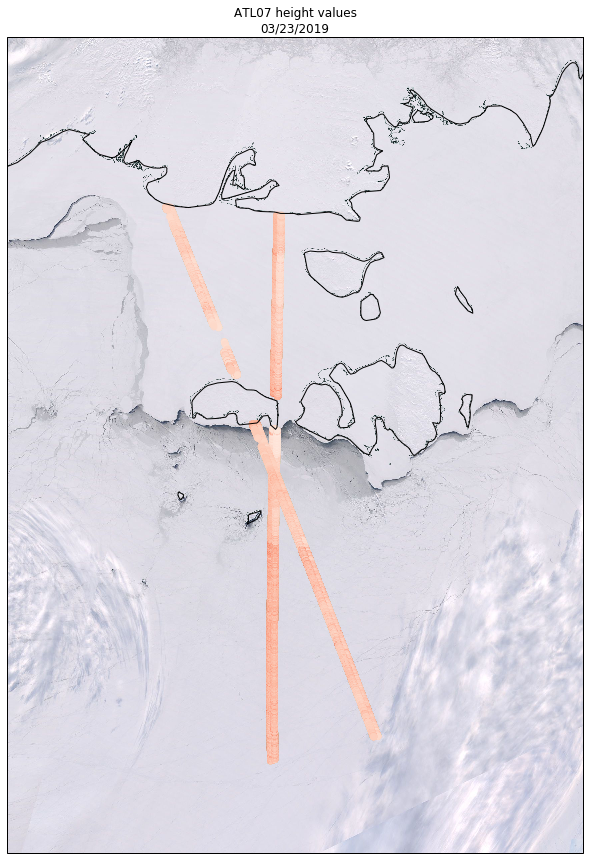

In [10]:
fig = plt.figure(figsize=(12, 15))
img = plt.imread(fname)

# ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45.0))
plot_proj = ccrs.Stereographic(central_longitude=-45, central_latitude=90, 
                               false_easting=0, false_northing=0,
                               true_scale_latitude=70)
ax = plt.axes(projection=plot_proj)
plt.title('ATL07 height values\n'
          '03/23/2019')

# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

# add the image. Because this image was a tif, the "origin" of the image is in the upper left corner
# ax.imshow(img, origin='upper', extent=bounds, transform=ccrs.NorthPolarStereo(central_longitude=-45.0))
ax.imshow(img, origin='upper', extent=bounds, transform=plot_proj)
ax.coastlines(resolution='50m', color='black', linewidth=1)

#Subset boundaries
#ax.plot(140, 72, 'bo', markersize=7, transform=ccrs.Geodetic())
#ax.plot(153, 80, 'bo', markersize=7, transform=ccrs.Geodetic())

#plt.plot(gdf.longitude,gdf.latitude,'o', transform=ccrs.Geodetic())
              
              
#scatter city data, with color reflecting population
# and size reflecting area
heights = ax.scatter(gdf_all.longitude, gdf_all.latitude, transform=ccrs.Geodetic(),
          c=gdf_all.height_segment_height,
          cmap='Reds', alpha=0.5)              

#cbar = fig.colorbar(heights, ax=ax)

plt.show()

# HOW TO FIX THE PROJECTION OFFSET??


#### How does this look in 3d?

In [ ]:
# From OpenAltimetry notebook:

# # Paste the OpenAltimetry selection parameters here
# OA_REFERENCE_URL = 'minx=72.0476&miny=36.6165&maxx=72.0505&maxy=36.6214&date=2019-05-02&trackId=516'
# # We populate a list with the photon data using the OpenAltimetry API, no HDF! 
# OA_URL = 'https://openaltimetry.org/data/icesat2/getPhotonData?client=jupyter&' + OA_REFERENCE_URL

# OA_PHOTONS = ['Noise', 'Low', 'Medium', 'High']
# # OA_PLOTTED_BEAMS = [1,2,3,4,5,6] you can select up to 6 beams for each ground track.
# # Some beams may not be usable due cloud covering or QC issues.
# OA_BEAMS = [3,4]

# df_beams = []
# oa_plots = []

# # This function will request the 6 tracks using OpenAltimetry's API
# def getPhotonData():
#     series = []
#     beam_index = 0;
#     for beam in OA_BEAMS:
#         beam_index += 1
#         b_url = OA_URL + '&beam=' + str(beam)
#         print(b_url)
#         print('Requesting Beam {}'.format(beam_index))
#         r = requests.get(b_url)
#         data = r.json()
#         series.append(data)
#     print ('Data requests completed you can now plot it on the next cell...')
#     return series

        
# photon_cloud = getPhotonData()

# track_index = 0
# for track in photon_cloud:
#     track_index +=1
#     for photons in track['series']:
#         if any(word in photons['name'] for word in OA_PHOTONS):
#             series = []
#             for p in photons['data']:
#                 series.append({
#                     'lat': p[0],
#                     'lon': p[2],
#                     'h': p[1]
#                 })
#             if (len(series) > 0):
#                 df = pd.DataFrame.from_dict(series)
#                 df.name = 'Beam ' + str(track_index) + ' ' + photons['name']
#                 df_beams.append(df) 

# for df in df_beams:
#     oa_plots.append(go.Scatter3d(name=df.name, x=df['lat'], y=df['lon'], z=df['h'], mode='markers',
#                                     marker=dict(
#                                         size=1,
#                                         color=df['h'],
#                                         colorscale='Viridis',   # choose a colorscale
#                                         opacity=0.8
#                                     )
#                                 )
#                    )
    
    
# layout = go.Layout(
#     width=900,
#     height=600,
#     scene = dict(aspectmode = 'manual', aspectratio =dict(x=1, y=1, z=0.5),
#                  xaxis=dict(title='Latitude'), yaxis=dict(title='Longitude'), zaxis=dict(title='Elevation (m)'))
# )

# fig = go.Figure(data=oa_plots, layout=layout)  

# iplot(fig)


# # Now we can get a histogram of the beam's elevation and their description
# for df in df_beams:
#     print(df.describe())
#     df.hist('h', bins=128)
    

### Overlay ATL07 values over MODIS Ice Surface Temperature



* Plot IS-2 track on MOD29 IST data
    * Same as for WorldView but using IST
    * May need/want a land mask

Before we plot the ATL07 heights over MODIS IST, we need to convert the Ice_Surface_Temperature values to kelvins. According to the [MOD29 User Guide](https://nsidc.org/data/mod29#title11) the Ice_Surface_Temperature (IST) values are "stored as calibrated data. To convert to kelvins, use scale_factor = 0.01 and add_offset = 0.0 in the following equation:

IST = scale_factor × (calibrated data - add_offset)

The valid range for ISTs is 210 K to 313.20 K."

Let's apply this conversion to our xarray:

In [11]:
# Apply calibrated data to kelvin conversion

mod29['Ice_Surface_Temperature'] = mod29['Ice_Surface_Temperature']*(0.01)

In [12]:
img = mod29.Ice_Surface_Temperature.hvplot.image().redim.range(Ice_Surface_Temperature=(240, 270))
img.options(cmap='PiYG_r')
#img.options(cmap='viridis')

:Image   [Cross_swath_pixels_1km:MOD_Swath_Sea_Ice,Along_swath_lines_1km:MOD_Swath_Sea_Ice]   (Ice_Surface_Temperature)

In [13]:
# HOW TO ADD ATL07 HEIGHTS OVER IST, LIKE ABOVE WITH THE CORRECTED REFLECTANCE IMAGE? STARTED TO PLAY WITH HVPLOT AND THIS LED TO PAGE UNRESPONSIVE:
from holoviews.operation.datashader import datashade
datashade(atl07_df.hvplot.points(x='longitude', y='latitude'))

/home/trst2284/miniconda3/envs/is2/lib/python3.7/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


:DynamicMap   []
   :RGB   [longitude,latitude]   (R,G,B,A)

## Extract MODIS IST values along the ICESat-2 tracks

Now that we've visually inspected height and IST values, let's do some analysis. We will now extract MODIS IST values at each ATL07 point.

* Match up MODIS and ICESat-2 values – depending on IS-2 segment length vs. MODIS footprint, may simply do nearest neighbor, or may want to average (bin) on or the other
* Use MODIS footprint as the baseline and match/bin IS-2 to each MODIS observation

In [ ]:
min_lon, max_lon = mod29.Longitude.min(), mod29.Longitude.max()
min_lat, max_lat = mod29.Latitude.min(), mod29.Latitude.max()
mod29_boundary = Polygon(
    [
        (min_lon, min_lat), 
        (max_lon, min_lat), 
        (max_lon, max_lat), 
        (min_lon, max_lat), 
        (min_lon, min_lat)
    ]
)

### Filtering to MOD29 granule bounding box

In [ ]:
# Not sure if this is necessary since we subsetted MODIS and ATLAS data

# gdf = gdf[gdf.intersects(mod29_boundary)]
# gdf

### Converting 'delta_time' to datetime values

In [ ]:
EPOCH = datetime(2018, 1, 1, 0, 0, 0)

def convert_delta_time(delta_time):
    '''
    Convert ICESat-2 'delta_time' parameter to UTC datetime
    '''
    utc_datetime = EPOCH + timedelta(seconds=delta_time)

    return utc_datetime

In [ ]:
# gdf_all['utc_datetime'] = gdf_all['delta_time'].apply(convert_delta_time)
# gdf_all = gdf_all.drop(columns='delta_time')

gdf_single['utc_datetime'] = gdf_single['delta_time'].apply(convert_delta_time)
gdf_single = gdf_single.drop(columns='delta_time')


### Compute along track distance

In [ ]:
# Warning: rather slow operation here, takes a few minutes for 200000 points

#distance = gdf_all.groupby(['filename', 'beam']).apply(functions.compute_along_track_distance)

In [ ]:
# Warning: rather slow operation here, takes a few minutes for 200000 points
distance_single = gdf_single.groupby(['filename','beam']).apply(functions.compute_along_track_distance)

In [ ]:
# Convert pandas series to list

distance_list = distance_single.tolist()

In [ ]:
# Create new gdf with distance added

gdf_dist = gdf_single.assign(distance = distance_list)

In [ ]:
#gdf_dist = gdf_all.assign(distance = distance_list)

### Convert back to pandas dataframe

Have both for good measure (different plotting api's mainly)

In [ ]:
#df_all = pd.DataFrame(gdf_dist.drop(columns='geometry'))

df_single = pd.DataFrame(gdf_dist.drop(columns='geometry'))

### Interpolating MOD29 onto ICESat-2 points

To easily interpolate MOD29 to ICESat-2 points, we can use the `pyresample` library. The `radius_of_influence` parameter determines maximum radius to look for nearest neighbor interpolation.

In [ ]:
#icesat2_geometry_all = prs.geometry.SwathDefinition(lons=df_all['longitude'], lats=df_all['latitude'])
icesat2_geometry_single = prs.geometry.SwathDefinition(lons=df_single['longitude'], lats=df_single['latitude'])
mod29_geometry = prs.geometry.SwathDefinition(lons=mod29['Longitude'], lats=mod29['Latitude'])
#df_all['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_all, radius_of_influence=1000, fill_value=np.nan)
df_single['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_single, radius_of_influence=1000, fill_value=np.nan)

In [ ]:
#mask_all = df_all['mod29_ice_surface_temperature'] == 50
#df_all['mod29_ice_surface_temperature'][mask_all] = np.nan

mask_single = df_single['mod29_ice_surface_temperature'] == 50
df_single['mod29_ice_surface_temperature'][mask_single] = np.nan

## Plot MODIS IST (MOD29) and ICESat-2 height/freeboard along tracks (X-axis = position, Y-axis = IST and height)

* This should show cold IST over the fast ice with fairly flat and higher ICESat-2 heights
* Warm IST will be seen in open water, thin ice just off the fast ice boundary
    * IST will decrease along transect
    * IS-2 should show low heights, but probably low quality (at least for ATL10, if any are available)

### First, plot against time:

In [ ]:
## Using pandas plotting (matplotlib backend)
# fig, ax = plt.subplots(figsize=(10, 3))
# df_all.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax)
# df_all.plot(x='utc_datetime', y='height_segment_height', ax=ax, secondary_y=True)

In [ ]:
# Using pandas plotting (matplotlib backend)
fig, ax = plt.subplots(figsize=(15, 5))
df_single.plot(x='utc_datetime', y='height_segment_height', ax=ax)
df_single.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

### Now plot against distance

We will split the plot by each beam.

In [ ]:
# separate each beam

gt1l = df_single['beam']=='gt1l'
gt2l = df_single['beam']=='gt2l'
gt3l = df_single['beam']=='gt3l'

In [ ]:
# # separate each beam

# gt1l = df_all['beam']=='gt1l'
# gt2l = df_all['beam']=='gt2l'
# gt3l = df_all['beam']=='gt3l'

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
df_single[gt1l].plot(x='distance', y='height_segment_height', ax=ax)
df_single[gt1l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

fig, ax = plt.subplots(figsize=(15, 5))
df_single[gt2l].plot(x='distance', y='height_segment_height', ax=ax)
df_single[gt2l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

fig, ax = plt.subplots(figsize=(15, 5))
df_single[gt3l].plot(x='distance', y='height_segment_height', ax=ax)
df_single[gt3l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 5))
# df_all[gt1l].plot(x='distance', y='height_segment_height', ax=ax)
# df_all[gt1l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

# fig, ax = plt.subplots(figsize=(15, 5))
# df_all[gt2l].plot(x='distance', y='height_segment_height', ax=ax)
# df_all[gt2l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

# fig, ax = plt.subplots(figsize=(15, 5))
# df_all[gt3l].plot(x='distance', y='height_segment_height', ax=ax)
# df_all[gt3l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

In [ ]:
# Using 'hvplot' (interactive - bokeh backend)
df_single.hvplot(x='distance', y='height_segment_height', by='beam', subplots=True).cols(1)

In [ ]:
(df_single.hvplot(x='distance', y='height_segment_height') + \
df_single.hvplot(x='distance', y='mod29_ice_surface_temperature')).cols(1)

### Plot MODIS IST vs. ICESat-2: scatterplot (X-axis = IST, Y-axis = IS-2 height)

* Should show a pretty clear relationship
    * Over fast ice: IST should be close to constant and height will also be fairly constant
    * Over drift ice, where it goes from thin ice toward thicker ice, should see height increasing as IST decreases
    * If we use IST = 271.2 K for open water and then find the IST at the first valid ATL10 value, we have the IST value at that freeboard. Then can use that relationship to get thin ice freeboard where there is ATL07 data, but not ATL10


In [ ]:
#THIS CRASHES THE HUB! 

#df_all.hvplot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height', c='distance')

In [ ]:
# df_single.plot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height', c='utc_datetime')
df_single.plot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height')

### Data filtering by quality flag

For each beam group within each file, filter `/sea_ice_segments/heights/height_segment_height` based on `/sea_ice_segments/heights/height_segment_quality`. According to the [User Guide](https://nsidc.org/data/ATL07#title38):

height_segment_quality: a binary indicator (1 = good, 0 = bad) of segment quality

In [ ]:
qual_filter = df_single['height_segment_quality']==1

In [ ]:
# Using pandas plotting (matplotlib backend)
fig, ax = plt.subplots(figsize=(15, 5))
df_single[qual_filter].plot(x='utc_datetime', y='height_segment_height', ax=ax)
df_single[qual_filter].plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

In [ ]:
df_single[qual_filter].plot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height')

#High temps are getting filtered out - more open water.

In [ ]:
## add ATL10 now? This could show coverage and show the freeboard estimate. 

### Add AMSR2 (AU_SI6) 89V-H difference to MODIS IST and ICESat-2 plots

* Difference for open water/thin ice large (~40-50 K), for thicker ice near zero (<10 K)
* Or calculate the polarization ratio (PR) = (89V – 89H)/(89V + 89H), which is commonly used in the PM sea ice community
* In theory can get concentration from PR (or 89 difference), but don’t really need to do that here.


### A couple other possibilities:
* Compare cross-over points between tracks 1298 and 1305. 
    * This is over drift ice, but might be able to correlate between them
    * Using all strong beams, there are 9 cross-over points, so there is 
* Compare 1298 repeat track from 12/22/2018 and 3/23/2019
    * For fast ice, should see an increase in height from Dec to Mar as snow depth and ice thickness increases
        * From a quick look at OA, I’m not really seeing this though
        * Not much from ATL10
        * Lots of data in ATL07, but don’t really see a connection – in fact Dec looks lower than Mar; this could be due to corrections/quality issues